In [63]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [65]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [66]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Harris, Mr. Henry Birkhardt",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [67]:
test.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Larsson-Rondberg, Mr. Edvard A",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


Looks like there are missing values in Age, Cabin, and Embarked. One missing fare in the test set as well. We'll handle these individually in a bit. 

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


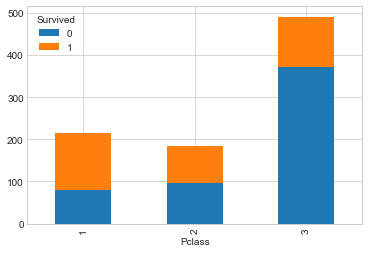

In [69]:
train.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True)

Passengers in the first two Pclasses had higher overall survival rates.

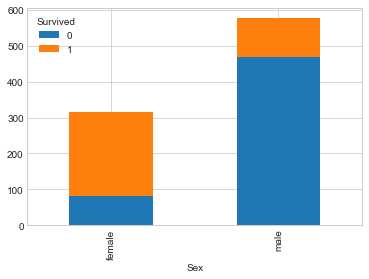

In [70]:
train.pivot_table('PassengerId', 'Sex', 'Survived', 'count').plot(kind='bar', stacked=True)

Clearly, females had a better survivial rate compared to males.

Title of passengers could tell us some information about their social class status. Let's pull that out.

In [71]:
train['Title'] =  train['Name'].apply(lambda x: (x.split('.')[0]).split(' ')[-1])
test['Title'] =  test['Name'].apply(lambda x: (x.split('.')[0]).split(' ')[-1])

train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Mme           1
Ms            1
Jonkheer      1
Sir           1
Capt          1
Countess      1
Lady          1
Don           1
Name: Title, dtype: int64

We can try to condense some of these titles into larger groups.

In [72]:
titles = {'Capt':       'Officer',
          'Col':        'Officer',
          'Major':      'Officer',
          'Jonkheer':   'Nobility',
          'Don':        'Nobility',
          'Sir' :       'Nobility',
          'Dr':         'Dr',
          'Rev':        'Rev',
          'Countess':   'Nobility',
          'Dona':       'Nobility',
          'Mme':        'Mrs',
          'Mlle':       'Ms',
          'Ms':         'Ms',
          'Mr' :        'Mr',
          'Mrs' :       'Mrs',
          'Miss' :      'Ms',
          'Master' :    'Master',
          'Lady' :      'Nobility'
                    } 

for k,v in titles.items():
    train.loc[train['Title'] == k, 'Title'] = v
    test.loc[test['Title'] == k, 'Title'] = v


train['Title'].value_counts()
test['Title'].value_counts()

Mr          240
Ms           79
Mrs          72
Master       21
Rev           2
Officer       2
Dr            1
Nobility      1
Name: Title, dtype: int64

# Age

To handle the missing ages, a simple median does not seem good enough. Let's take median ages from within gender and their respective titles.

In [73]:
print(train.groupby(['Sex', 'Title',])['Age'].median())

Sex     Title   
female  Dr          49.0
        Mrs         35.0
        Ms          21.0
        Nobility    40.5
male    Dr          44.0
        Master       3.5
        Mr          30.0
        Nobility    40.0
        Officer     56.0
        Rev         46.5
Name: Age, dtype: float64


In [74]:
train['Age'] = train.groupby(['Sex','Title'])['Age'].apply(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby(['Sex','Title'])['Age'].apply(lambda x: x.fillna(x.median()))

Let's create some age groups.

In [75]:
def AgeGroup(x):
    if x <= 11:
        return 0
    elif x <= 20: 
        return 1
    elif x <= 30:
        return 2
    elif x <= 40:
        return 3
    elif x <= 50:
        return 4
    elif x <= 60:
        return 5
    else:
        return 6
    
train['AgeGroup'] = train['Age'].apply(lambda x : AgeGroup(x))
test['AgeGroup'] = test['Age'].apply(lambda x : AgeGroup(x))

In [76]:
train['AgeGroup'].value_counts()

2    385
3    172
1    111
4     87
0     72
5     42
6     22
Name: AgeGroup, dtype: int64

# Parch & SibSp

Parch and SibSp together lets us know if relatives on aboard. I suspect family are less likely to get separated and left on the ship. 

In [77]:
train['Family'] = train['Parch'] + train['SibSp']
test['Family'] = test['Parch'] + test['SibSp']

Let's group these family members in different sized groups. I tried a few combinations but this one worked out the best

In [78]:
def FamSize(x):

    if x == 1 or x == 2:
        return 'small'
    elif x == 3 or x == 4:
        return 'medium'
    elif x >= 5:
        return 'large'
    else:
        return 'alone'

train['Family'] = train['Family'].apply(lambda x : FamSize(x))
test['Family'] = test['Family'].apply(lambda x : FamSize(x))

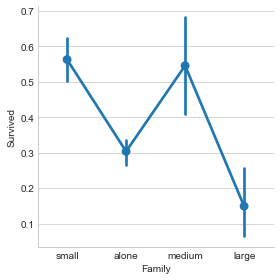

In [79]:
Fsize = sns.factorplot('Family','Survived', data=train,  )

We can see here small and medium sized familiy had higher survival rates.

# Fare

Let's replace the single missing fare in test set with a simple median. Additionally, let us group the fares into buckets using the quartiles.  

In [80]:
test['Fare'] = test.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median()))


_, bins = pd.qcut(train.Fare, q=5, retbins=True)
bins = np.concatenate(([-np.inf], bins[1:-1], [np.inf]))

train['FareGroup'] = pd.cut(train.Fare, bins, labels=False)
test['FareGroup'] = pd.cut(test.Fare, bins, labels=False)


train['FareGroup'].value_counts()

1    184
3    180
0    179
4    176
2    172
Name: FareGroup, dtype: int64

# Cabin

There are a variety of different cabins. My inital thought was to remove this altogether. However, it turned out this was quite informative.

In [81]:
train['Cabin'].value_counts()

C23 C25 C27        4
G6                 4
B96 B98            4
F2                 3
C22 C26            3
D                  3
E101               3
F33                3
B58 B60            2
D20                2
E24                2
B35                2
C93                2
E25                2
C68                2
F G73              2
C123               2
D36                2
E67                2
B18                2
E33                2
F4                 2
B5                 2
C2                 2
B57 B59 B63 B66    2
B20                2
B22                2
C92                2
D17                2
E121               2
                  ..
C103               1
D15                1
B3                 1
A6                 1
D46                1
F38                1
B82 B84            1
C106               1
B30                1
C95                1
D45                1
C30                1
A36                1
C87                1
A20                1
E40                1
E10          

Let's take the first letter in the cabin.

In [82]:
train.Cabin.fillna('U',inplace=True)
test.Cabin.fillna('U',inplace=True)

train['Cabin'] = train['Cabin'].map(lambda x: x[0])
test['Cabin'] = test['Cabin'].map(lambda x: x[0])


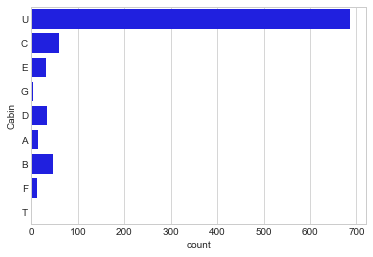

In [83]:
f, ax = plt.subplots(figsize=(6, 4))
sns.countplot(y='Cabin', data=train, color='b')

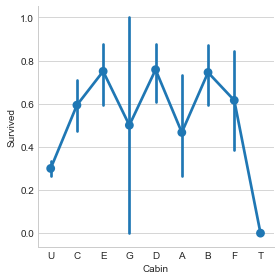

In [84]:
sns.factorplot('Cabin','Survived', data=train,  )

We can see here, cabin does determine which passengers were able to get a lifeboat.

# Embarked

We replace the missing values with the most common one.

In [85]:
MedEmbarked = train.groupby('Embarked').count()['PassengerId']
train.Embarked.fillna(MedEmbarked, inplace=True)

# Data Prep

In [86]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,Family,FareGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Mr,2,small,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,3,small,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Ms,2,alone,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs,3,small,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Mr,3,alone,1


In [87]:
#Drop unnecessary columns
to_drop = ['Ticket', 'Name', 'SibSp', 'Parch', 'Age', 'Fare']
for i in to_drop:
    train.drop([i], axis=1, inplace=True)
    test.drop([i], axis=1, inplace=True)

In [88]:
train.head()

,PassengerId,Survived,Pclass,Sex,Cabin,Embarked,Title,AgeGroup,Family,FareGroup
0,1,0,3,male,U,S,Mr,2,small,0
1,2,1,1,female,C,C,Mrs,3,small,4
2,3,1,3,female,U,S,Ms,2,alone,1
3,4,1,1,female,C,S,Mrs,3,small,4
4,5,0,3,male,U,S,Mr,3,alone,1


Since we are dealing with categorical variables, we need to get dummies for each one of these.

In [89]:
train = pd.get_dummies(data=train, columns=['Pclass', 'Sex','Cabin','Embarked','Title','AgeGroup','Family','FareGroup'])
test = pd.get_dummies(data=test, columns=['Pclass', 'Sex','Cabin','Embarked','Title','AgeGroup','Family','FareGroup'])

In [90]:
X_train = train.drop('Survived',axis=1)
Y_train = train['Survived']
X_test  = test

Here we can see the feature importance.

In [91]:
clf = RandomForestClassifier(n_estimators = 15,
                                criterion = 'gini',
                                max_features = 'sqrt',
                                max_depth = None,                                
                                min_samples_split =7,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 18)
clf = clf.fit(X_train, Y_train)
indices = np.argsort(clf.feature_importances_)[::-1]

print('Feature ranking:')
for f in range(X_train.shape[1]):
    print('%d. feature %d %s (%f)' % (f + 1, indices[f], X_train.columns[indices[f]], clf.feature_importances_[indices[f]]))

Feature ranking:
1. feature 20 Title_Mr (0.199038)
2. feature 4 Sex_female (0.152809)
3. feature 22 Title_Ms (0.093747)
4. feature 3 Pclass_3 (0.073552)
5. feature 5 Sex_male (0.068994)
6. feature 21 Title_Mrs (0.060639)
7. feature 14 Cabin_U (0.047646)
8. feature 0 PassengerId (0.034644)
9. feature 41 FareGroup_4 (0.033145)
10. feature 2 Pclass_2 (0.024610)
11. feature 1 Pclass_1 (0.022174)
12. feature 34 Family_large (0.021576)
13. feature 38 FareGroup_1 (0.019551)
14. feature 15 Embarked_C (0.017787)
15. feature 37 FareGroup_0 (0.017337)
16. feature 19 Title_Master (0.014933)
17. feature 36 Family_small (0.012080)
18. feature 10 Cabin_E (0.010204)
19. feature 25 Title_Rev (0.009252)
20. feature 26 AgeGroup_0 (0.009043)
21. feature 40 FareGroup_3 (0.008935)
22. feature 17 Embarked_S (0.005859)
23. feature 16 Embarked_Q (0.005844)
24. feature 35 Family_medium (0.005462)
25. feature 33 Family_alone (0.005025)
26. feature 32 AgeGroup_6 (0.004624)
27. feature 30 AgeGroup_4 (0.004296)
28.

Let us use the most important ones.

In [92]:
model = SelectFromModel(clf, prefit=True)
train_new = model.transform(X_train)
train_new.shape

(891, 10)

In [93]:
best_features = X_train.columns[indices[0:train_new.shape[1]]]
X = X_train[best_features]
Xt = X_test[best_features]
best_features

Index(['Title_Mr', 'Sex_female', 'Title_Ms', 'Pclass_3', 'Sex_male',
       'Title_Mrs', 'Cabin_U', 'PassengerId', 'FareGroup_4', 'Pclass_2'],
      dtype='object')

We end up with 10 features. It's not surprising that sex is imporant - we know boats were given to women and children. Additionally, unknown cabin is important as well.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_train, test_size=0.33, random_state=123)

Following was found here: https://www.kaggle.com/creepykoala/study-of-tree-and-forest-algorithms
A great visualization how certain parameters effect the random forest score.

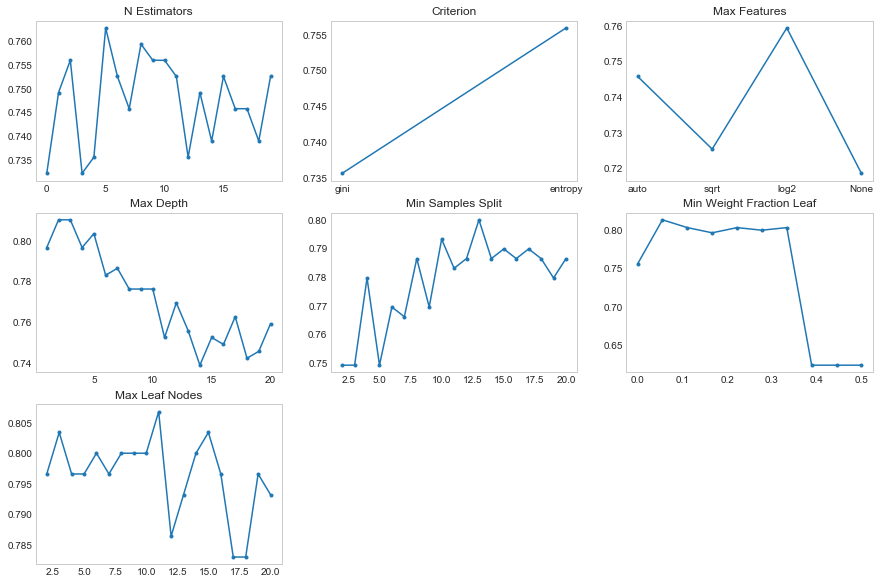

In [101]:
plt.figure(figsize=(15,10))

#N Estimators
plt.subplot(3,3,1)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores, '.-')
plt.axis('tight')
plt.title('N Estimators')
plt.grid();

#Criterion
plt.subplot(3,3,2)
feature_param = ['gini','entropy']
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(criterion=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores, '.-')
plt.title('Criterion')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Features
plt.subplot(3,3,3)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores, '.-')
plt.axis('tight')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(3,3,4)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(3,3,5)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Min Samples Split')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Max Leaf Nodes')
plt.grid();

In [102]:
rf = RandomForestClassifier()

parameter_grid = {'n_estimators' : [15, 100, 200],
                  'criterion' : ['gini', 'entropy'],
                  'max_depth' : [None, 50],
                  'min_samples_split' : [7, 11],
                  'max_leaf_nodes' : [18, 20]
                 }

grid_search = GridSearchCV(rf, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(X, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7946127946127947
Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 18, 'min_samples_split': 11, 'n_estimators': 15}


In [103]:
rf = RandomForestClassifier(n_estimators = 15,
                                criterion = 'gini',
                                max_depth = None,
                                min_samples_split =11,
                                max_leaf_nodes = 18)

rf.fit(X, Y_train)
Y_pred_RF = rf.predict(Xt)

rf.score(X_test,y_test)

0.8305084745762712

In [104]:
submission = pd.DataFrame({
        'PassengerId': test['PassengerId'],
        'Survived': Y_pred_RF
    })
submission.to_csv('titanic.csv', index=False)

Ended up with around 77%. I didn't go for a perfect model, just wanted to use some of my skills.